# Выбор локации для скважины

### Цель проекта: построить модель для определения региона, где добыча принесёт наибольшую прибыль, проанализировать возможную прибыль и риски техникой Bootstrap.

### Описание проекта:

Добывающей компании «ГлавРосГосНефть» необходимо решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерены качество нефти и объём её запасов. 
Данные геологоразведки трёх регионов находятся в файлах, в каждом файле содержится уникальный идентификатор скважины (id), три признака точек (f0, f1, f2) - неважно, что они означают, но сами признаки значимы. Также в данных указан объем запасов скажины (product) в тыс. баррелей.

Для выбора локации необходимо выполнить следующие действия:

- В избранном регионе найти месторождения, для каждого определить значения признаков;
- Построить модель и оценить объём запасов;
- Выбрать месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Вычислить прибыль, которая равна суммарной прибыли отобранных месторождений.

### Условия задачи:


- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

<h1>Содержание:<span class="tocSkip"></span></h1>




<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данныхх</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков </a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Загрузка и подготовка данных

In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Объявляем константы

STATE = np.random.RandomState(12345)

# Количество точек для исследования
SELECTION = 500
# Количество отобранных лучших точек для разработки
CHOSEN = 200
# Бюджет на разработку скважин (млн руб.)
BUDGET = 10000 
# Доход с одной единицы продукта (млн руб.)
REVENUE_PER_PRODUCT = 0.45

In [3]:
# Загружаем данные из файла в датафрейм

try:    
    geo_data_0 = pd.read_csv('Downloads/geo_data_0.csv')
    geo_data_1 = pd.read_csv('Downloads/geo_data_1.csv')
    geo_data_2 = pd.read_csv('Downloads/geo_data_2.csv')
    
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    
pd.set_option('display.float_format', '{:.3f}'.format)

In [4]:
# Изучим данные

display(geo_data_0.head())
geo_data_0.info()

display(geo_data_1.head())
geo_data_1.info()

display(geo_data_2.head())
geo_data_2.info()

,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# Посмотрим на основные статистические характеристики данных и проверим их на наличие выбросов

display(geo_data_0.describe())
display(geo_data_1.describe())
display(geo_data_2.describe())

,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.500,0.250,2.503,92.500
std,0.872,0.504,3.248,44.289
min,-1.409,-0.848,-12.088,0.000
25%,-0.073,-0.201,0.288,56.498
50%,0.502,0.250,2.516,91.850
75%,1.074,0.701,4.715,128.564
max,2.362,1.344,16.004,185.364


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,1.141,-4.797,2.495,68.825
std,8.966,5.120,1.704,45.944
min,-31.610,-26.359,-0.018,0.000
25%,-6.299,-8.268,1.000,26.953
50%,1.153,-4.813,2.011,57.086
75%,8.621,-1.333,4.000,107.813
max,29.422,18.734,5.020,137.945


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.002,-0.002,2.495,95.000
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.009,2.484,94.926
75%,1.159,1.164,4.859,130.595
max,7.238,7.845,16.739,190.030


In [6]:
# Проверим данные на наличие пропусков

print(geo_data_0.isna().sum())
print(geo_data_1.isna().sum())
print(geo_data_2.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Пропусков в данных нет

In [7]:
# Проверим данные на наличие явных дубликатов

print(geo_data_0.duplicated().sum() + geo_data_1.duplicated().sum() + geo_data_2.duplicated().sum())

0


В предоставленных данных столбец 'id' описывает состояние уникальной скважины. Это означает, что в каждом датасете не может быть двух и более записей для одного и того же 'id'. Проверим данные на наличие неявных дубликатов и удалим их:

In [8]:
# Удаляем неявные дубликаты (строки с повторяющимися идентификаторами скважины)

geo_data_0 = geo_data_0.drop_duplicates(subset=['id'])
geo_data_1 = geo_data_1.drop_duplicates(subset=['id'])
geo_data_2 = geo_data_2.drop_duplicates(subset=['id'])

geo_data_0.info()
geo_data_1.info()
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
--

После удаления дубликатов в первом наборе данных осталось 99990 строк (удалено 10 дубликатов), во втором и третьем по 99996 строк (удалено 4 дубликата). 

In [9]:
# Создадим новые наборы данных без столбца с ненужной информацией

data_0 = geo_data_0.drop('id', axis=1)
data_1 = geo_data_1.drop('id', axis=1)
data_2 = geo_data_2.drop('id', axis=1)

In [10]:
data_0.head()

,f0,f1,f2,product
0,0.706,-0.498,1.221,105.280
1,1.335,-0.340,4.365,73.038
2,1.023,0.152,1.420,85.266
3,-0.032,0.139,2.979,168.621
4,1.988,0.155,4.752,154.037


In [11]:
# Проведем корреляционный анализ признаков

display(data_0.corr())
display(data_1.corr())
display(data_2.corr())

,f0,f1,f2,product
f0,1.000,-0.441,-0.003,0.144
f1,-0.441,1.000,0.002,-0.192
f2,-0.003,0.002,1.000,0.484
product,0.144,-0.192,0.484,1.000


,f0,f1,f2,product
f0,1.000,0.182,-0.002,-0.031
f1,0.182,1.000,-0.003,-0.010
f2,-0.002,-0.003,1.000,0.999
product,-0.031,-0.010,0.999,1.000


,f0,f1,f2,product
f0,1.000,0.001,-0.000,-0.002
f1,0.001,1.000,0.001,-0.001
f2,-0.000,0.001,1.000,0.446
product,-0.002,-0.001,0.446,1.000


Можно сказать, что во всех трех датасетах нет мультиколлинеарности, поскольку зависимость между признаками f0, f1 и f2 практически равна нулю. Однако стоит отметить, что признак f2 влияет на значение product намного сильнее остальных. В первом и третьем наборе данных наблюдается средняя зависимость между f2 и product (около 0.5), а во втором регионе коэффициент коррелляции равен 0.999. 

count   99990.000
mean       92.500
std        44.288
min         0.000
25%        56.497
50%        91.848
75%       128.564
max       185.364
Name: product, dtype: float64

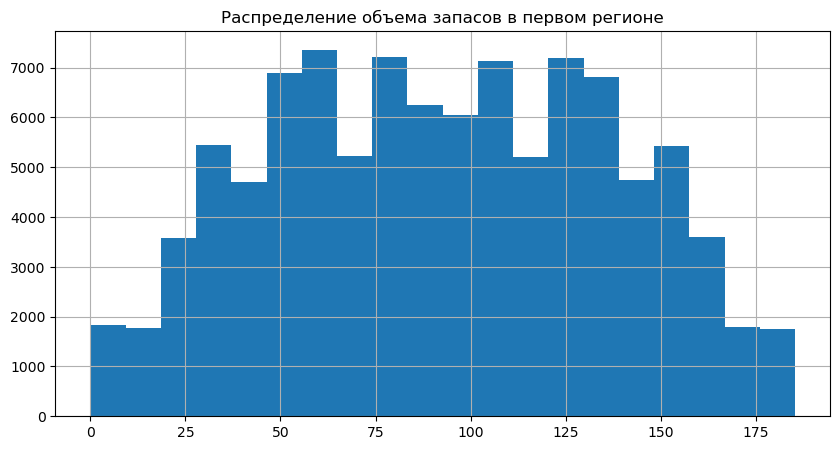

In [12]:
# Посмотрим на распределение целевой переменной product

display(data_0['product'].describe())
data_0.hist('product', bins = 20, figsize = (10, 5));
plt.title('Распределение объема запасов в первом регионе')
plt.show()

count   99996.000
mean       68.824
std        45.945
min         0.000
25%        26.953
50%        57.086
75%       107.813
max       137.945
Name: product, dtype: float64

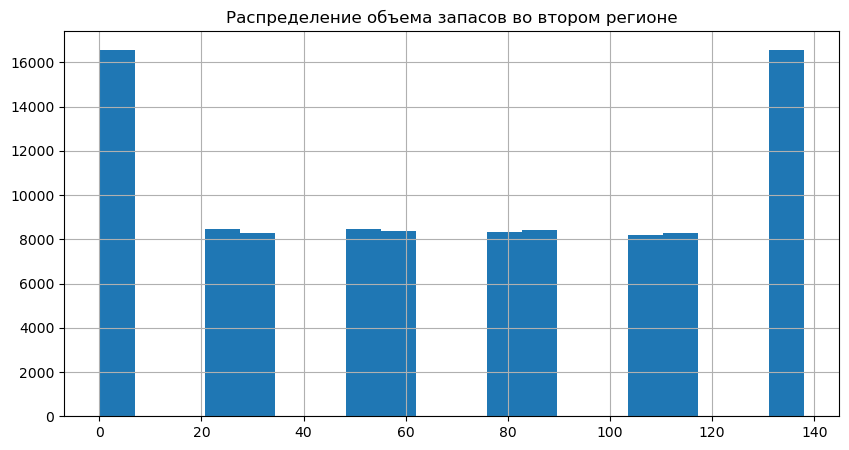

In [13]:
display(data_1['product'].describe())
data_1.hist('product', bins = 20, figsize = (10, 5));
plt.title('Распределение объема запасов во втором регионе')
plt.show()

count   99996.000
mean       94.998
std        44.750
min         0.000
25%        59.450
50%        94.925
75%       130.587
max       190.030
Name: product, dtype: float64

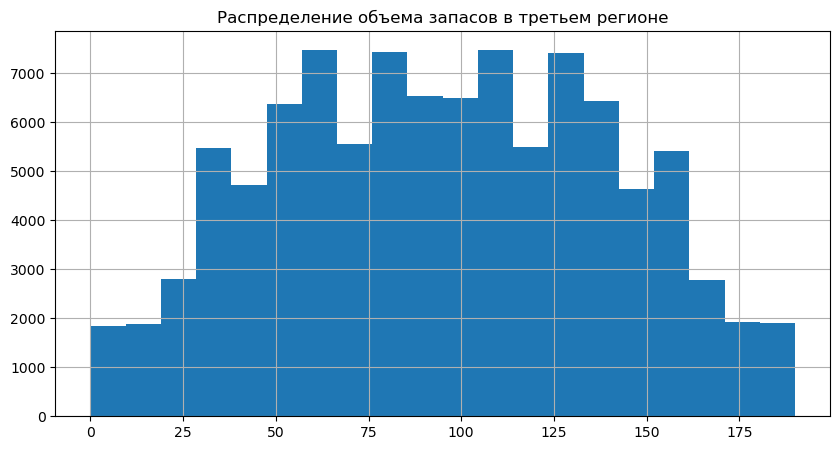

In [14]:
display(data_2['product'].describe())
data_2.hist('product', bins = 20, figsize = (10, 5));
plt.title('Распределение объема запасов в третьем регионе')
plt.show()

Судя по графикам, данные столбца `product` распределены примерно одинаково (почти нормально) в первом и третьем регионах. Распределение целевой переменной во втором регионе сильно отличается: очень много аномальных значений (как высоких, так и низких). 

В результате загрузки и изучения данных можно сделать несколько выводов:
- Датасеты содержат пять столбцов, 99990 строк в первом и 99996 строк во втором и третьем. Выявлены и удалены строки с повторяющимися id скважин. Выбросов и пропусков в данных не обнаружено;
- Проведен коррелляционный анализ признаков. Анализ показал, что между обучающими признаками зависимости нет;
- Значения запасов скважин распределены похожим образом в первом и третьем регионах. Во втором регионе целевая переменная распределена с особенностями: очень много аномально низких и аномально высоких значений;
- Для того, чтобы алгоритмам было легче обучать модели, признаки необходимо привести к одному масштабу;
- Удален столбец, содержащий уникальные идентификаторы скважин, поскольку информация в нем никак не влияет на результат исследования. 

## Обучение и проверка модели

In [15]:
# Напишем функцию, которая произведет извлечение признаков и целевого признака, разделит данные на обучающую и валидационную выборки, 
# а также проведет масштабирование данных

def processing(data):
    
#   Извлекаем признаки и целевой признак
    features = data.drop('product', axis=1)
    target = data['product']

#   Делим данные на обучающую и валидационную
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, 
                                                                                  random_state=STATE)
#   Масштабируем признаки
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid   

In [16]:
# Применяем функцию к данным из каждого региона

features_train_0, features_valid_0, target_train_0, target_valid_0 = processing(data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = processing(data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = processing(data_2)

print('Размер обучающей выборки:', len(features_train_0)+len(target_train_0) , 'строк')
print('Размер валидационной выборки:', len(features_valid_0)+len(target_valid_0), 'строки')

Размер обучающей выборки: 149984 строк
Размер валидационной выборки: 49996 строки


In [17]:
features_train_0.head()

,f0,f1,f2
75167,0.776,-1.255,-0.068
43242,-1.580,-0.177,-1.282
91995,-0.646,0.137,-0.505
5094,-0.509,1.254,-0.857
78252,-0.738,1.534,-0.373


In [18]:
features_train_0.describe()

,f0,f1,f2
count,74992.000,74992.000,74992.000
mean,-0.000,0.000,0.000
std,1.000,1.000,1.000
min,-2.189,-2.177,-3.899
25%,-0.657,-0.893,-0.682
50%,-0.002,0.002,0.006
75%,0.657,0.895,0.683
max,2.138,2.145,3.989


In [19]:
# Напишем функцию для обучения моделей

def learning(features_train, features_valid, target_train, target_valid):
    
#   Обучаем модель и получаем предсказанные значения объема сырья
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
#   Высчитываем среднее предсказанное значение объема сырья и значение RMSE
    pred_mean = predicted_valid.mean()
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    
    return predicted_valid, pred_mean, rmse

In [20]:
# Применяем функцию learning для каждого региона

predicted_valid_0, pred_mean_0, rmse_0 = learning(features_train_0, features_valid_0, target_train_0, target_valid_0)
predicted_valid_1, pred_mean_1, rmse_1 = learning(features_train_1, features_valid_1, target_train_1, target_valid_1)
predicted_valid_2, pred_mean_2, rmse_2 = learning(features_train_2, features_valid_2, target_train_2, target_valid_2)

# Напечатаем результаты
print(f'Cредний запас предсказанного сырья в первом регионе равен {pred_mean_0}, RMSE модели {rmse_0}.')
print(f'Cредний запас предсказанного сырья во втором регионе равен {pred_mean_1}, RMSE модели {rmse_1}.')
print(f'Cредний запас предсказанного сырья в третьем регионе равен {pred_mean_2}, RMSE модели {rmse_2}.')

Cредний запас предсказанного сырья в первом регионе равен 92.78915638280621, RMSE модели 37.853527328872964.
Cредний запас предсказанного сырья во втором регионе равен 68.95746560835222, RMSE модели 0.8947795612491991.
Cредний запас предсказанного сырья в третьем регионе равен 95.07949668343952, RMSE модели 40.04155743522127.


В результате обучения моделей и анализа полученных предсказаний можно сделать пару выводов:

- В первом и третьем регионах модели показали высокое значение среднего запаса предсказанного сырья, однако при этом показали довольно высокое значение среднеквадратичной ошибки.
- Модель, обученная для подсчета среднего запаса предсказанного сырья во втором регионе, показала значение запаса скважин меньше, но её RMSE очень близко к нулю, что говорит о высоком качестве данной модели.


## Подготовка к расчёту прибыли

In [21]:
# Расчет бюджета на разработку одной скважины
budget_per_chosen = BUDGET / CHOSEN 

# Расчет достаточного объём сырья для безубыточной разработки новой скважины
sufficient_volume = budget_per_chosen / REVENUE_PER_PRODUCT
print(f'Достаточный объём сырья для безубыточной разработки новой скважины равен {sufficient_volume} тыс. баррелей.')

Достаточный объём сырья для безубыточной разработки новой скважины равен 111.11111111111111 тыс. баррелей.


In [22]:
# Сравним полученный необходимый объем сырья со средним запасом в каждом регионе


print('Регион 1:', data_0['product'].mean())
print('Регион 2:', data_1['product'].mean())
print('Регион 3:', data_2['product'].mean())

Регион 1: 92.49968421774354
Регион 2: 68.82391591804064
Регион 3: 94.99834211933378


#### Вывод:

Среднее значение запаса скважин во всех трех регионах ниже необходимого объема для безубыточной разработки новой скважины. Это значит, что
вероятность убытка довольно высока при случайном выборе 200 скважин. Для дальнейшей работы необходимо создать такую модель, которая на основе имеющихся данных могла отобрать 200 точек с максимальным объемом сырья и вычислить финансовый результат работы в них. Чтобы оценить прибыль и риски работы в каждом регионе, необходимо подсчитать среднее от полученных результатов, отбирая точки случайным образом  множество раз. В этом поможет техника bootstrap.

## Расчёт прибыли и рисков 

In [23]:
# Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

def revenue(target, probabilities, count):
    
    target = target.reset_index(drop=True)
    probs_sorted = pd.Series(probabilities, index=target.index)
    selected = target[probs_sorted.sort_values(ascending = False).index][:count]
    
    return selected.sum() * REVENUE_PER_PRODUCT - BUDGET

In [24]:
# Применим функцию и посчитаем прибыль для каждого региона

print(f'Прибыль в первом регионе - {revenue(target_valid_0, predicted_valid_0, CHOSEN)} млн руб.')
print(f'Прибыль в первом регионе - {revenue(target_valid_1, predicted_valid_1, CHOSEN)} млн руб.')
print(f'Прибыль в первом регионе - {revenue(target_valid_2, predicted_valid_2, CHOSEN)} млн руб.')

Прибыль в первом регионе - 3365.1872377002874 млн руб.
Прибыль в первом регионе - 2415.086696681512 млн руб.
Прибыль в первом регионе - 2458.130096355624 млн руб.


Далее посчитаем риски и прибыль для каждого региона, учитывая условие задачи: найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков в каждом регионе при случайном выборе 500 скважин. 

In [25]:
# Напишем функцию для вычисления прибыли и убытков с применением техники Bootstrap

def bootstrap(target, probabilities, count):
    
#   Создаем пустой список для записи значений прибыли с каждой итерации
    values = []
    for i in range(1000):      
#       Выбираем из списка с целевыми значениями необходимое количество скважин
        target_subsample = target.reset_index(drop=True).sample(n=SELECTION, replace=True, random_state=STATE)
    
#       Выбранные случайно скважины ищем в списке с предсказанными значениями по индексам
        probs_subsample = probabilities[target_subsample.index]
    
#       Полученные данные используем для расчета прибыли в функции revenue, результат сохраняем в списке values
        values.append(revenue(target_subsample, probs_subsample, CHOSEN))
    
    values = pd.Series(values)
    
#   В переменной loss сохраняем значение, равное вероятности убытка
    loss = values[values<0].count()/1000

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print('Средняя прибыль в регионе равна:', values.mean(), 'млн руб.')
    print('95% доверительный интервал лежит в диапазоне от {:.2f}'.format(lower),'до {:.2f}'.format(upper))
    print('Вероятность убытка равна: {:.2%}'.format(loss))

In [26]:
# Считаем прибыль и вероятность убытка в первом регионе

bootstrap(target_valid_0, predicted_valid_0, SELECTION)

Средняя прибыль в регионе равна: 389.04448855708534 млн руб.
95% доверительный интервал лежит в диапазоне от -112.97 до 894.00
Вероятность убытка равна: 7.40%


In [27]:
# Считаем прибыль и вероятность убытка во втором регионе

bootstrap(target_valid_1, predicted_valid_1, SELECTION)

Средняя прибыль в регионе равна: 439.07238851576784 млн руб.
95% доверительный интервал лежит в диапазоне от 33.06 до 850.15
Вероятность убытка равна: 1.30%


In [28]:
# Считаем прибыль и вероятность убытка в третьем регионе

bootstrap(target_valid_2, predicted_valid_2, SELECTION)

Средняя прибыль в регионе равна: 450.22471351034454 млн руб.
95% доверительный интервал лежит в диапазоне от -62.39 до 943.66
Вероятность убытка равна: 4.60%


#### Вывод:

Расчеты средней прибыли и убытков показали, что единственным оптимальным выбором для разработки является регион №2. Риск убытка в этом регионе самый низкий (1.30%, что ниже допустимого порога в 2.5%), а средняя прибыль равна около 439 млн. руб.

## Итоговый вывод

- В ходе работы были изучены три набора данных, содержащих по 100000 строк и 5 столбцов. Были обработаны дубликаты, пропуски и дубликаты не обнаружены;
- Столбец, содержащий уникальные идентификаторы скважин, был удален из датасетов, поскольку информация в нем никак не влияет на результаты настоящего исследования;
- Для того, чтобы алгоритмам было легче обучать модели, признаки были приведены к одному масштабу;

На основе обработанных данных были обучены модели для предсказания среднего запаса сырья в каждом из трех регионов. Анализ полученных результатов позволил сделать следующие выводы:
- В первом и третьем регионах модели показали высокое значение среднего запаса предсказанного сырья, однако при этом показали довольно высокое значение среднеквадратичной ошибки.
- Модель, обученная для подсчета среднего запаса предсказанного сырья во втором регионе, показала значение запаса скважин меньше, но её RMSE очень близко к нулю, что говорит о высоком качестве данной модели.

Далее был произведен расчет достаточного объёма сырья для безубыточной разработки новой скважины. Результат составил около 111 тыс. баррелей. После сравнения полученного результата со средним запасом скважин в каждом регионе, оказалось, что среднее значение запаса скважин во всех трех регионах ниже необходимого объема для безубыточной разработки новой скважины. Поэтому случайный выбор скважин в любом регионе может привести к убыткам.

Для того, чтобы добыча принесла максимальную прибыль, следующим этапом работы стало написание функции revenue для расчёта прибыли по выбранным скважинам и предсказаниям модели. Её суть заключается в отборе скважин с наибольшим значением предсказанного объема сырья и вычислении прибыли от полученного общего объема. 

Для подсчета рисков и прибыли для каждого региона была написана функция bootstrap, которая:
- применяет технику Bootstrap с 1000 выборок и находит распределение прибыли, подсчитанной функцией revenue
- считает среднюю прибыль, 95%-й доверительный интервал и риск убытков

Расчеты показали следующие результаты:
- Для первого региона:
    - Средняя прибыль равна около 389 млн рублей;
    - 95% доверительный интервал лежит в диапазоне от -112.97 млн руб до 894 млн руб;
    - Вероятность убытка от добычи сырья в первом регионе равна 7.40%, что намного больше допустимого значения в 2.5%
    
- Для второго региона: 
    - Средняя прибыль равна около 439 млн рублей;
    - 95% доверительный интервал лежит в диапазоне от 33.06 млн руб до 850.15 млн руб;
    - Вероятность убытка от добычи сырья в первом регионе равна 1.30%, что ниже допустимого значения в 2.5%
- Для третьего региона: 
    - Средняя прибыль равна около 450 млн рублей;
    - 95% доверительный интервал лежит в диапазоне от -62.39 млн руб до 943.66 млн руб;
    - Вероятность убытка от добычи сырья в первом регионе равна 4.60%, что больше допустимого значения в 2.5% 

### Таким образом, единственным оптимальным выбором для разработки является второй регион. Риск убытка в нем самый низкий, а средняя прибыль равна 439 млн рублей.